(chap_bit_depths_imagej)=
# ImageJ: Types & bit-depths

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

The bit-depth and type of an image is determined before it is opened in ImageJ.
If the data is clipped, it's already wrong before we begin -- and no amount of ImageJ wizardry will get the information back.


Here, we will explore how to:

* Check the bit-depth and type
* Diagnose when clipping may have occurred
* Convert the bit-depth and height -- carefully -- if needed


## Checking the bit-depth & type

Bit-depth and type are related to one another: both are needed to convert binary data into pixel values.
ImageJ does not always make a careful distinction between the two.

The full list of image types supported by ImageJ is found in the {menuselection}`Image --> Type --> ` submenu.
The top three entries are the most important; they are
* **8-bit** -- unsigned integer
* **16-bit** -- unsigned integer
* **32-bit** -- floating point

Although these look like bit-depths, they are listed as 'types'.
But since an 8-bit and 16-bit images in ImageJ are *always* unsigned integer, and 32-bit images are *always* floating point, there is no ambiguity.

You can see the type of the current image by checking which item under {menuselection}`Image --> Type` has a tick next to it.
But you don't usually have to; you can also see the information at the top of the image window.

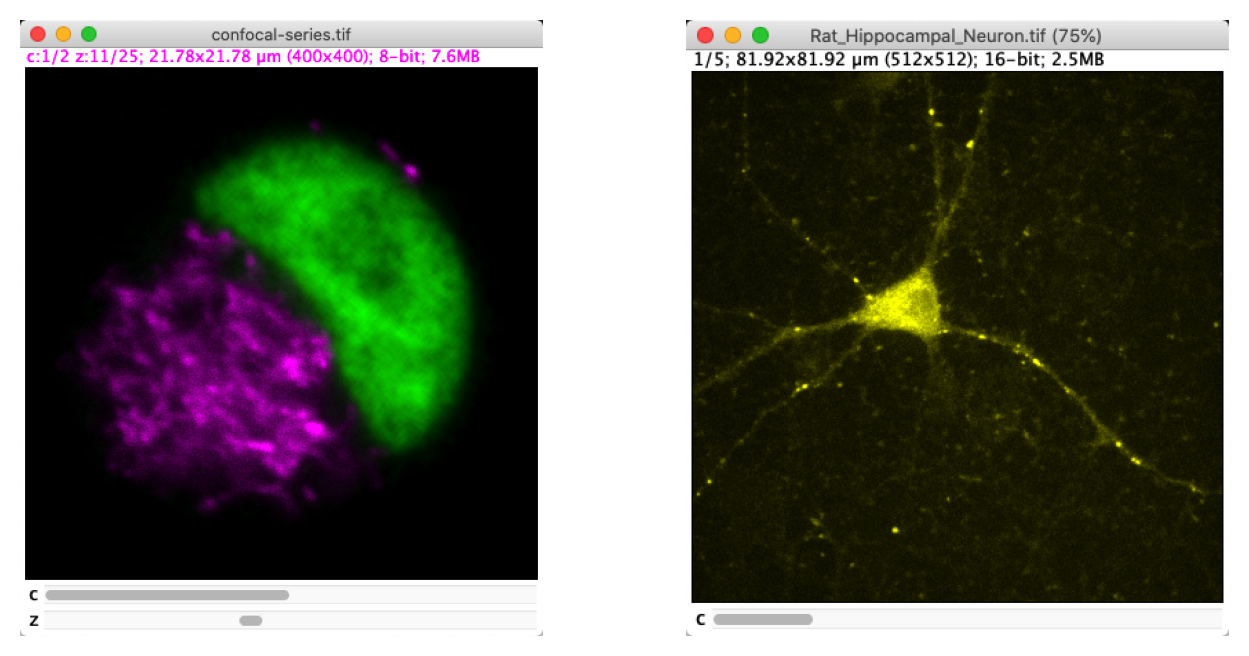

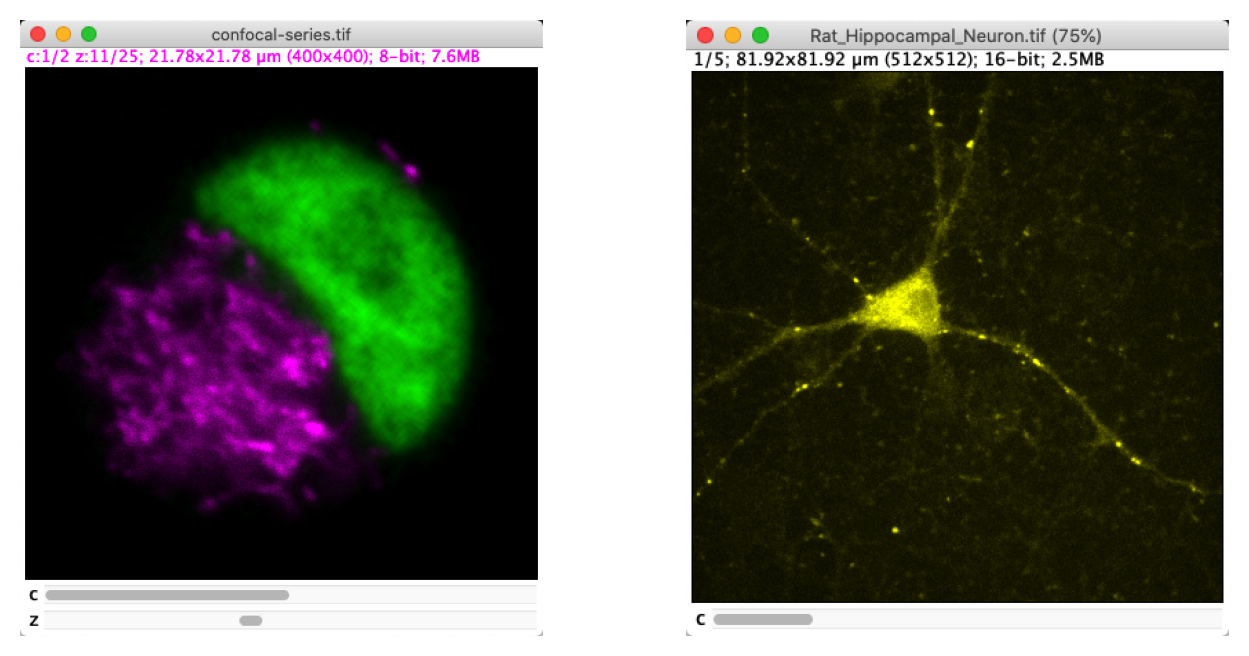

In [2]:
fig = create_figure(figsize=(8, 4))
show_image('images/type-window-series.png', pos=121)
show_image('images/type-window-neuron.png', pos=122)
glue_fig('fig_types_windows', fig)

```{glue:figure} fig_types_windows
---
align: center
name: fig-types_windows
---
The text at the top of each image window provides useful information.
Here, the image on the left is 8-bit and the image on the right is 16-bit.
```

There are various other types listed under {menuselection}`Image --> Type`, which all have an association with color.
These are less different than they first appear: an RGB image is really an 8-bit image with three channels (corresponding to red, green and blue).
We will explore this in {ref}`chap_colors`.


## Diagnosing problems

The biggest problem associated with an image's bit-depth and type is clipping.
{menuselection}`Analyze --> Histogram` is the essential command needed to diagnose if something is wrong -- just press {kbd}`H` to run it.

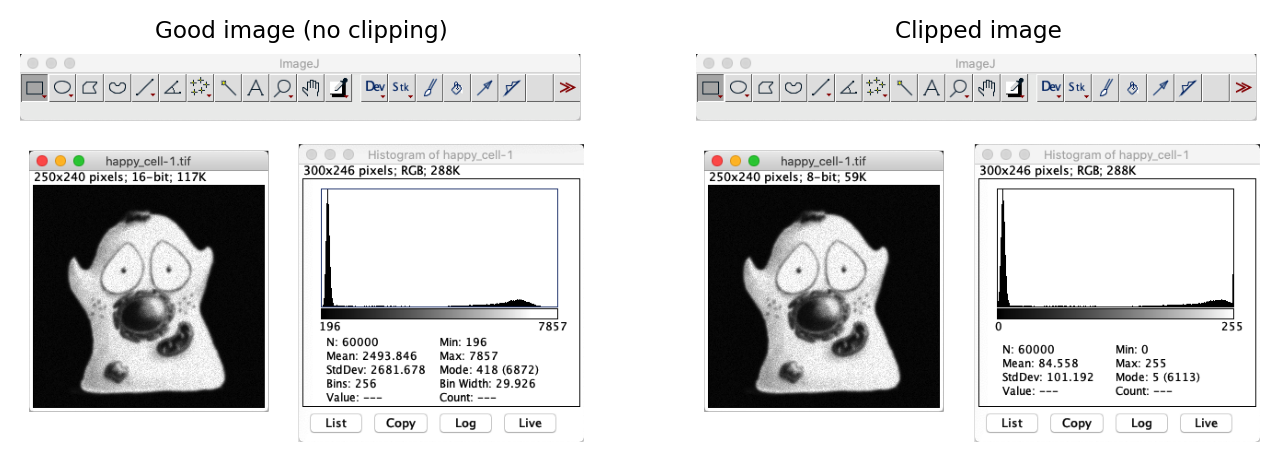

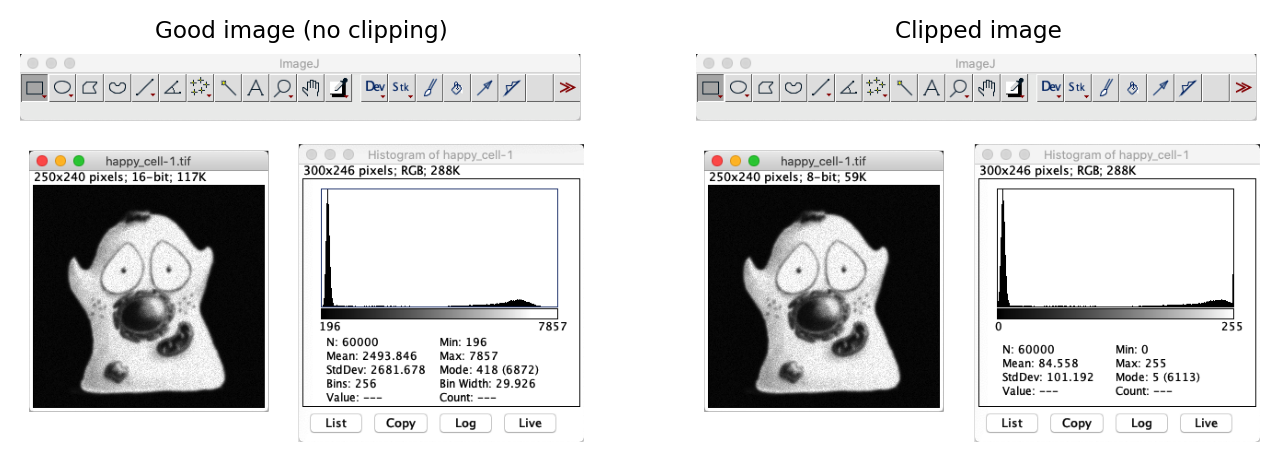

In [3]:
fig = create_figure(figsize=(8, 4))
show_image('images/imagej-histogram-unclipped.png', title="Good image (no clipping)", pos=121)
show_image('images/imagej-histogram-clipped.png', title="Clipped image", pos=122)
glue_fig('fig_types_imagej_clipping', fig)

```{glue:figure} fig_types_imagej_clipping
---
align: center
name: fig-types_imagej_clipping
---
Two similar-looking images and their histograms: one clipped, one not.
```

The main sign that an image was clipped is a big peak at either end of the histogram.
This can take some careful inspection to distinguish from the black border that surrounds the histogram in ImageJ.

If you know the bit-depth and type of the image, you can figure out the range (e.g. 0-255 for an 8-bit unsigned integer image, 0-65,535 for 16-bit) and usually that gives a good indication to where the peaks would be -- but it isn't a perfect guide.
Conceivably, we could have an image that was clipped at some other value because it has been rescaled *after* clipping.

`````{tab-set}

````{tab-item} Question

Does the image below show signs of having been clipped?

```{image} images/imagej-histogram-maybe.png
:align: center
:width: 60%
```
````

````{tab-item} Answer
Yes!
There is a small peak at the high end of the histogram, corresponding to pixel values of 4095.
This is itself a suspicious number because it would be the maximum possible value in a 12-bit unsigned integer image (i.e. 2<sup>12</sup> - 1) -- so my guess is that was the bit-depth of the acquisition device.

Admittedly, the image is not *very badly* clipped.
We could check the proportion of pixels with that value, and use this to estimate whether it is likely that the clipping will have a significant impact upon later analysis.
But it's better to avoid clipping altogether when possible.
````

`````

(sec_bit_depths_converting)=
## Converting images

There are three main scenarios when you might need to convert the type or bit-depth of an image:

* **Reducing the file size**
* **Converting to 8-bit to display the image in other software**
  * Because 8-bit images are more common outside of science
* **Converting to floating-point before doing image processing operations**
  * Because (as we will see later in the book) these often require fractions and negative numbers

Note that *reversing* the effects of clipping isn't in the list: if an image is clipped during acquisition, any later conversion won't help.
The clipped data is gone for good.

However, you can still introduce clipping after acquisition by making ill-advised conversions -- with all the unfortunate consequences of that.
Therefore it's important to know how ImageJ's type conversion works.


### Increasing the bit-depth

Let's start with the easy case: *increasing* the bit-depth of an image.

In principle, we can convert an image just by choosing the type we want from the {menuselection}`Image --> Type -->` submenu.

In ImageJ, there are only really three bit-depths and associated types.
This means that the only conversions that can increase the bit-depth are:
* 8-bit (unsigned integer) &rarr; 16-bit (unsigned integer)
* 8-bit (unsigned integer) &rarr; 32-bit (floating point)
* 16-bit (unsigned integer) &rarr; 32-bit (floating point)

Fortunately,
* any 8-bit unsigned integer value can be represented in a 16-bit unsigned integer image
* any 16-bit unsigned integer value can be represented in a 32-bit unsigned floating point image

Consequently, increasing the bit-depth *should* always be safe.
That being said...

:::{admonition} Always prepare for software to surprise us!
:class: tip

We shouldn't be complacent about image conversions, even if we think they *should* be ok.
It's so easy to measure images (press {kbd}`M`), we should always check before and after conversion to make sure the summary measurements are unchanged.
:::


### Reducing the bit-depth

Reducing the bit-depth is where the biggest dangers lurk.
Then not all values from a higher bit-depth image fit into an image with a lower bit-depth.

The process is the same: choose the type you want from the {menuselection}`Image --> Type -->` submenu.

But what happens next depends upon whether the option {guilabel}`Scale When Converting` under {menuselection}`Edit --> Options --> Conversions...` is checked or not.

* {guilabel}`Scale When Converting` **is _not_ checked:** pixels are simply given the closest valid value within the new bit depth, i.e. there is clipping and rounding as needed.
   * Example: If you convert an image to 8-bit, then no data will be lost *only* if every pixel value before conversion is an integer in the range 0--255. Every other value will be rounded or clipped.
* {guilabel}`Scale When Converting`**_is_ checked:** a constant is added or subtracted, then pixels are further divided by another constant before being assigned to the nearest valid value within the new bit depth. Only *then* is clipping or rounding applied if it is still needed.

{guilabel}`Scale When Converting` is on by default and, as suggested by {numref}`fig-bits_clipping`, is usually the best option.
The question then is where the constants come from to perform the rescaling.

Perhaps surprisingly, they are determined from the {guilabel}`Minimum` and {guilabel}`Maximum` in the current *Brightness/Contrast...* settings: the *Minimum* is subtracted, and the result is divided by *Maximum* - *Minimum*.
Any pixel value that was lower than *Minimum* or higher than *Maximum* ends up being clipped.
Consequently, **converting to a lower bit-depth with scaling can lead to different results depending upon what the brightness and contrast settings were**.

This means that, ideally, we would use a minimum value that is equal to the minimum pixel value in the image, and a maximum value equal to the maximum pixel value.
Fortunately, there is an easy way to achieve this:

:::{admonition} Reset the Brightness/Contrast range before reducing the bit-depth
:class: tip

If you **really** need to reduce the bit-depth of an image in ImageJ, you should usually open {menuselection}`Image --> Adjust --> Brightness/Contrast...` ({kbd}`Shift + C`) and press the {guilabel}`Reset` button first, to minimize the data lost to clipping or rounding.
:::

````{tab-set}

```{tab-item} Question

Why is scaling usually a good thing when reducing the bit-depth, and why is a constant usually subtracted before applying this scaling?

**Hint:** As an example, consider how a 16-bit image containing values in the range 4000–5000 might be converted to 8-bit first without scaling, and then alternatively by scaling with or without the initial constant subtraction.
What constants for subtraction and division would usually minimize the amount of information lost when converting to 8-bit image, limiting the errors to rounding only and not clipping?
```

```{tab-item} Answer
In the example given, converting to 8-bit without any scaling would result in all pixels simply becoming 255: all useful information in the image would be lost.

With scaling but without subtraction, it would make sense to divide all pixel values by the maximum in the image divided by the maximum in the new bit depth, i.e. by 5000/255.
This would then lead to an image in which pixels fall into the range 204–255. Much information has clearly been lost: 1000 potentially different values have now been squeezed into 52.

However, if we first subtract the smallest of our 16-bit values (i.e. 4000), our initial range becomes 0–1000. Divide then by 1000/255 and the new values become scaled across the full range of an 8-bit image, i.e. 0–255. We have still lost information – but considerably less than if we had not subtracted the constant first.
```

````

````{tab-set}

```{tab-item} Practical

Make sure that the {guilabel}`Scale When Converting` option is turned on (it should be by default).
Then using a suitable 8-bit sample image, e.g. {menuselection}`File --> Open Samples --> Boats`, explore the effects of brightness/contrast settings when increasing or decreasing bit-depths.

Can you destroy the image by simply 1) increasing the bit-depth, and the then 2) decreasing the bit-depth to its original value?

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/open-in-imagej-js-badge.svg)](https://ij.imjoy.io/?run=https://gist.github.com/petebankhead/6f9f451fdc0116197501ae504a57d5e7)
```

```{tab-item} Solution
It's generally a good idea to choose {guilabel}`Reset` in the {menuselection}`Brightness/Contrast...` window before reducing any bit-depths for 2D images (see {ref}`chap_multidimensional_processing` to read about special considerations related to *z*-stacks or time series).

You can destroy an image by increasing its bit-depth, adjusting the brightness/contrast and then decreasing the bit-depth to the original one again.
This may seem weird, because clearly the final bit-depth is *capable* of storing all the original pixel values.
But ImageJ does not know this and does not check, so it will simply do its normal bit-depth-reducing conversion based on contrast settings.
```

````